
# 📦 SmartSkin-Inspired Anomaly Detection using Autoencoders

This project is a **conceptual case study** inspired by SmartSkin Technologies’ sensor-driven quality monitoring systems in beverage bottling.

---

### ⚠️ Note on Dataset:
The dataset used here is **synthetically generated** to simulate real-world bottling line sensor features such as pressure, torque, vibration, and star wheel alignment error.  
It is **not sourced from SmartSkin**, but reflects their type of sensor data and use cases.

---

## 🧠 Project Scope

This notebook walks through the full journey of building a practical anomaly detection pipeline for manufacturing defects — from raw sensor data to insights.

---

### 📌 Step-by-Step Flow:

#### 🧼 1. Data Loading + Preprocessing
- Uploaded and explored raw CSV sensor data
- Reviewed column distributions and ensured data quality
- Normalized features using MinMaxScaler for neural network compatibility

#### 📊 2. Exploratory Data Analysis (EDA)
- Visualized distributions of sensor variables
- Identified skewness, outliers, and early hints of defects

#### 🌲 3. Feature Importance with Random Forest
- Trained a quick Random Forest to understand which features contribute most to defect prediction
- Identified top drivers like torque and star alignment error

#### 🧠 4. Autoencoder Model Development
- Built a 4-layer deep autoencoder using Keras (encoder → bottleneck → decoder)
- Used ReLU in hidden layers and sigmoid in the output layer
- Trained on normal (non-defective) data to teach the model “what normal looks like”

#### 🚨 5. Reconstruction Error + Anomaly Detection
- Reconstructed input data using the autoencoder and calculated reconstruction error (MSE)
- Bottles with high reconstruction error flagged as anomalies

#### 🎯 6. Threshold Optimization & Evaluation
- Tested 95th, 90th, and 85th percentile thresholds to flag outliers
- Evaluated performance via confusion matrix and classification report
- Best result: 94.5% accuracy, 96% precision, 75% recall

#### 📈 7. Visual Validation
- Bar chart comparison of actual defects vs. model-predicted anomalies
- Visually confirmed the model’s ability to catch real defects with minimal false alarms

#### 🔮 8. Future Enhancements
- Add hybrid classification layer to improve recall
- Introduce dual-thresholds for high-confidence + review zone detection
- Prepare model for live production-line integration

---

## 🎯 Objective:
To simulate how deep learning models like autoencoders can detect production defects in real-time and support high-quality decision-making in bottling environments like those served by SmartSkin Technologies.


# Improving Bottle Line Quality for Coca-Cola Using SmartSkin’s Sensor Data

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving coke_bottle_sensor_data.csv to coke_bottle_sensor_data.csv


In [2]:
import pandas as pd

df = pd.read_csv("coke_bottle_sensor_data.csv")
df.head()


,timestamp,bottle_id,pressure,vibration,temperature,line_speed,corner_force,packer_torque,star_alignment_error,defective
0,2025-04-01 08:00:00,COKE-0000,6.00,2.70,20.99,0.82,2.81,3.75,0,0
1,2025-04-01 08:00:30,COKE-0001,5.36,2.46,21.78,1.03,3.48,3.73,0,0
2,2025-04-01 08:01:00,COKE-0002,6.15,2.03,20.81,1.12,3.51,2.92,0,0
3,2025-04-01 08:01:30,COKE-0003,7.02,1.68,21.54,1.58,3.88,3.80,0,0
4,2025-04-01 08:02:00,COKE-0004,5.27,2.35,19.16,1.31,2.41,4.44,1,1



Each row = 1 bottle

Columns and it's description:

timestamp: When it passed through the line

bottle_id: Unique ID

pressure, vibration, temperature

line_speed, corner_force, packer_torque

star_alignment_error: Yes/No (0 or 1)

defective: Final label (1 = defective, 0 = good)

In [3]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             1000 non-null   object 
 1   bottle_id             1000 non-null   object 
 2   pressure              1000 non-null   float64
 3   vibration             1000 non-null   float64
 4   temperature           1000 non-null   float64
 5   line_speed            1000 non-null   float64
 6   corner_force          1000 non-null   float64
 7   packer_torque         1000 non-null   float64
 8   star_alignment_error  1000 non-null   int64  
 9   defective             1000 non-null   int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 78.3+ KB


,pressure,vibration,temperature,line_speed,corner_force,packer_torque,star_alignment_error,defective
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,5.519370,2.035520,22.008810,1.196240,3.46068,3.971950,0.140000,0.19300
std,0.979208,0.498859,1.475215,0.205597,0.79403,0.604274,0.347161,0.39485
min,2.260000,0.530000,17.470000,0.610000,0.96000,2.260000,0.000000,0.00000
25%,4.850000,1.700000,21.030000,1.050000,2.95000,3.580000,0.000000,0.00000
50%,5.525000,2.030000,22.000000,1.200000,3.48500,3.975000,0.000000,0.00000
75%,6.150000,2.362500,22.992500,1.330000,4.01250,4.370000,0.000000,0.00000
max,9.350000,3.600000,27.890000,1.850000,5.99000,5.860000,1.000000,1.00000


In [4]:
#Checking for missing values
df.isnull().sum()


,0
timestamp,0
bottle_id,0
pressure,0
vibration,0
temperature,0
line_speed,0
corner_force,0
packer_torque,0
star_alignment_error,0
defective,0


Checking Sensor Distribution

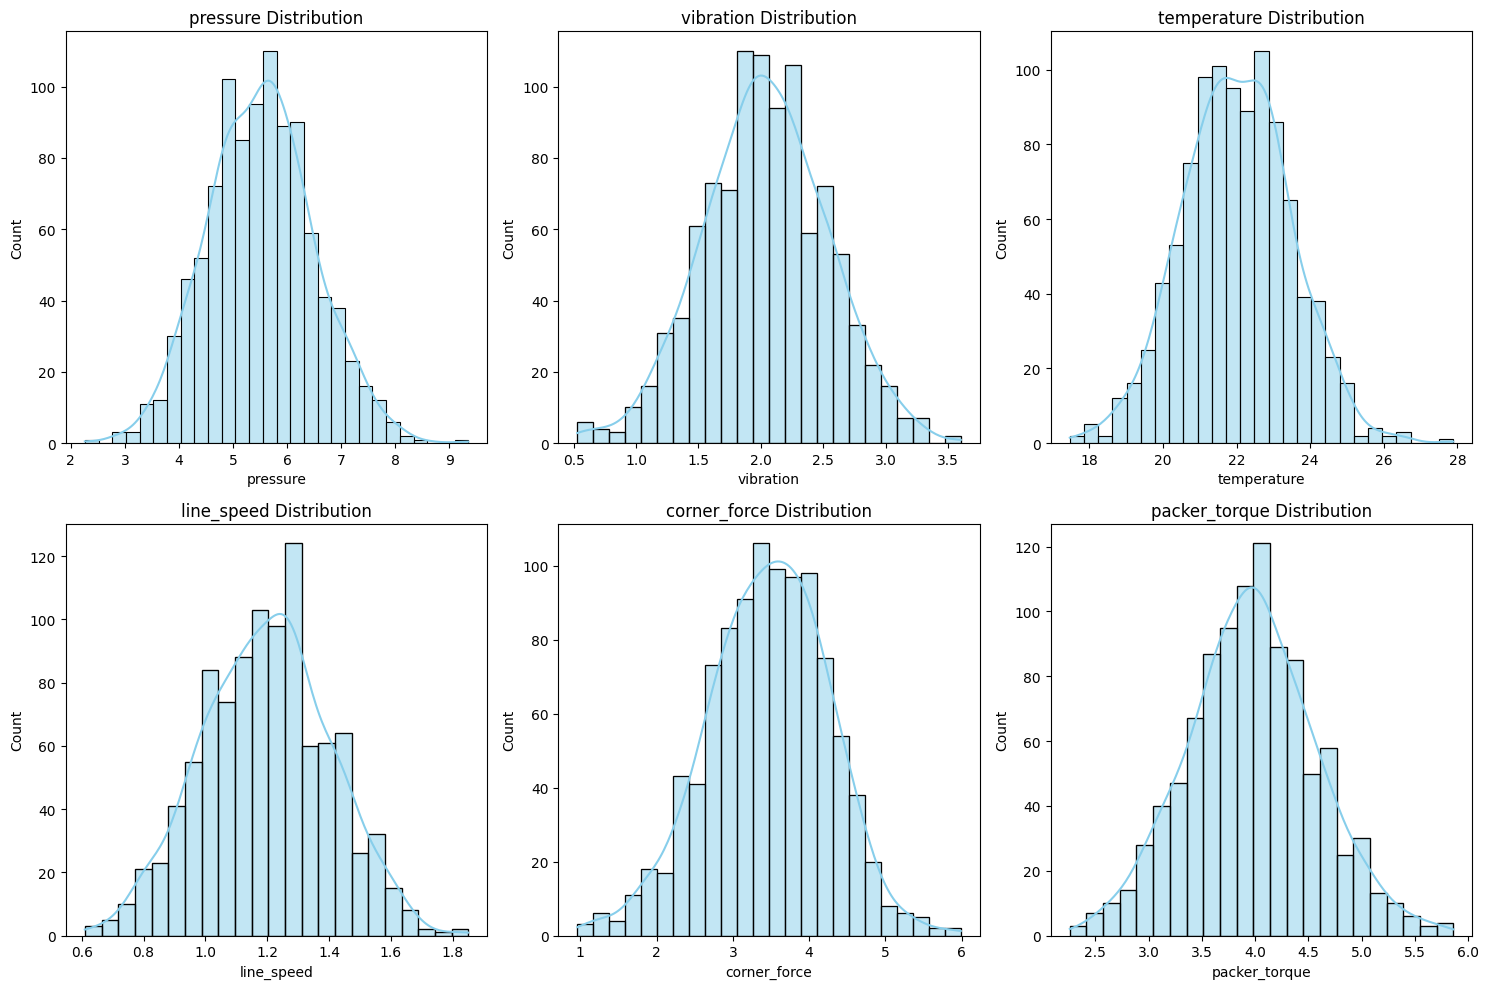

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sensor_cols = ['pressure', 'vibration', 'temperature', 'line_speed', 'corner_force', 'packer_torque']

for i, col in enumerate(sensor_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()


In [6]:
df['packer_torque'].describe()


,packer_torque
count,1000.000000
mean,3.971950
std,0.604274
min,2.260000
25%,3.580000
50%,3.975000
75%,4.370000
max,5.860000


Our packer machine typically applies about 4 Nm of force when sealing bottles.
Most bottles fall between 3.6 and 4.4 Nm, which seems stable.
However, a few bottles went as high as 5.86 Nm — that’s an over-tightening risk and might explain some of the defective ones.
We should investigate those high-torque cases and check if they’re linked to defect labels. Let's check correlation matrix before we move on.

Correlation Matrix





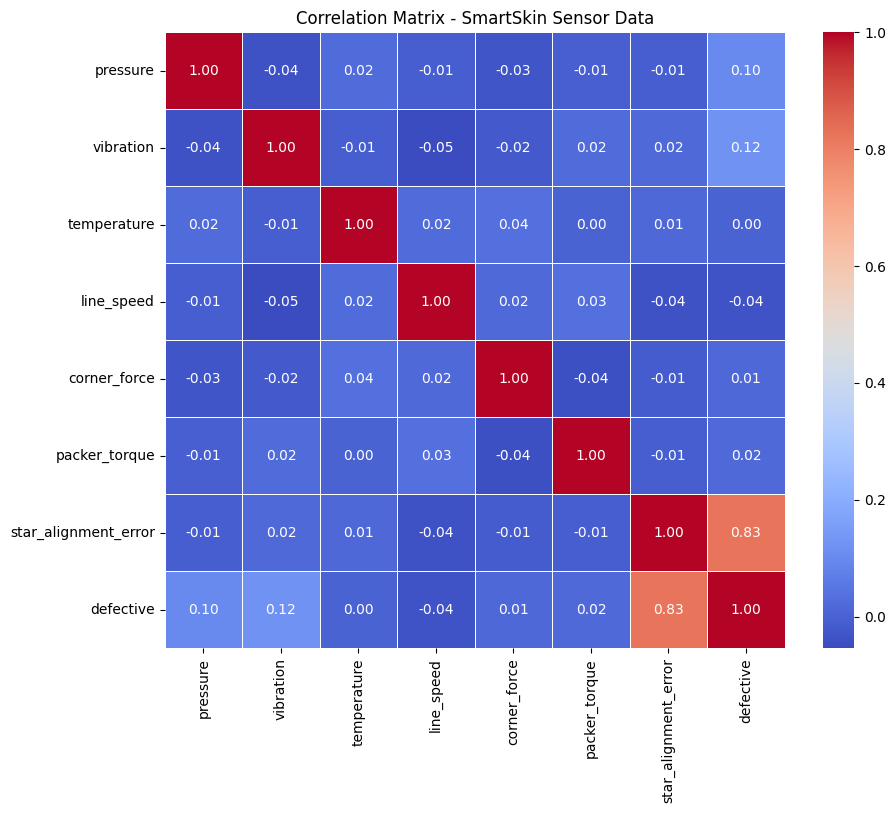

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of relevant columns
corr_columns = ['pressure', 'vibration', 'temperature', 'line_speed',
                'corner_force', 'packer_torque', 'star_alignment_error', 'defective']

# Compute correlation
corr_matrix = df[corr_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix - SmartSkin Sensor Data")
plt.show()


The most influential factor in predicting defects is star-wheel alignment error, with a correlation of 0.83.
Minor correlations are found with vibration and pressure.
The rest of the features seem neutral individually.

Model Selection:
I chose Random Forest because it handles real-world manufacturing data well — especially when there are complex, non-linear interactions between sensors. It’s also robust to noise, doesn’t need too much tuning, and gives insight into feature importance.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Define features and label
features = ['pressure', 'vibration', 'temperature', 'line_speed',
            'corner_force', 'packer_torque', 'star_alignment_error']
X = df[features]
y = df['defective']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.995
Confusion Matrix:
 [[161   1]
 [  0  38]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       162
           1       0.97      1.00      0.99        38

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



 Class 0 (Not Defective Bottles)
Precision = 1.00
All bottles predicted as “good” were truly good.
Recall = 0.99
It found 161 out of 162 non-defective correctly (missed 1)
F1-score = 1.00
Balance between precision and recall is strong

Class 1 (Defective Bottles)
Precision = 0.97
Out of all predicted as defective, 97% actually were
Recall = 1.00
It caught every defective bottle — zero missed
F1-score = 0.99
Near perfect!

The Random Forest model achieved 99.5% accuracy, with a perfect recall on the defective class — meaning it didn’t miss any faulty bottles, which is crucial in quality control.
Even better, the model had only 1 false alarm, showing it’s both reliable and precise

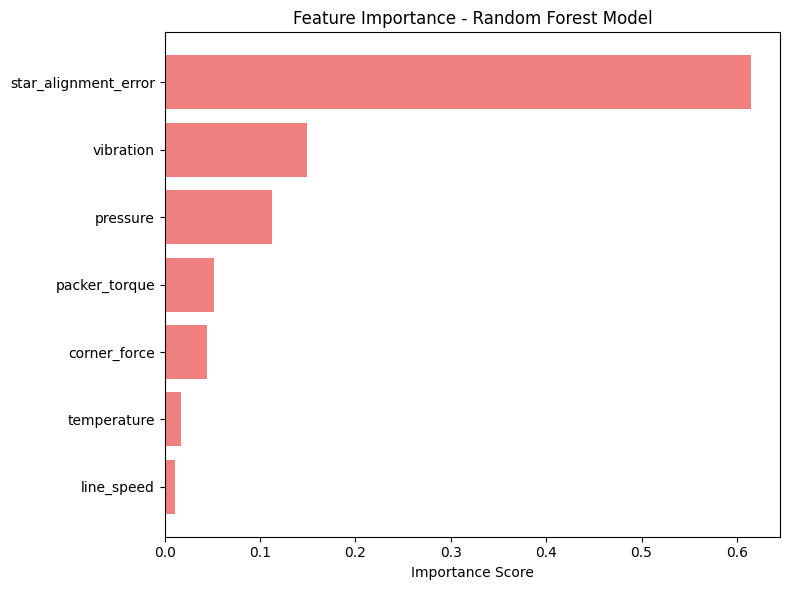

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Step 2: Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightcoral')
plt.title("Feature Importance - Random Forest Model")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


The Random Forest model clearly identified star-wheel alignment error as the leading contributor to defects — scoring over 60% of the model’s attention.
This makes sense operationally, as alignment issues affect multiple downstream processes including vibration, pressure, and torque.
Vibration and pressure are also key contributors and might serve as early warning signals for mechanical irregularities.
Sensors like temperature and line speed had minimal impact, indicating they may be less valuable in defect prediction — or require more granular readings.

**Building & Training the Auto Encoder**

I used Keras with TensorFlow backend to simplify the architecture and training.
Keras let me define layers and activations intuitively, while TensorFlow handled the optimization and learning behind the scenes

In [10]:
# Filter only bottles that are not defective
normal_df = df[df['defective'] == 0]

# Select sensor features only (no labels)
sensor_cols = ['pressure', 'vibration', 'temperature', 'line_speed',
               'corner_force', 'packer_torque', 'star_alignment_error']

X_normal = normal_df[sensor_cols]


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# You can also normalize the full dataset for later scoring
X_full_scaled = scaler.transform(df[sensor_cols])


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

# Build the autoencoder
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(5, activation='relu'),
    Dense(3, activation='relu'),
    Dense(5, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


I built a 4-layer autoencoder using Keras. The encoder compresses normal bottle sensor readings into a 3-unit code, and the decoder tries to reconstruct the original input.
If the bottle is normal, reconstruction is accurate. If it’s abnormal, the error is high — which we flag as an anomaly.
I used ReLU activations in hidden layers for pattern learning, sigmoid in the output for scaled data, and Adam optimizer for fast and stable convergence.

In [19]:
# Train the autoencoder
history = autoencoder.fit(
    X_normal_scaled, X_normal_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0675 - val_loss: 0.0679
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0631 - val_loss: 0.0652
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0620 - val_loss: 0.0630
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0589 - val_loss: 0.0608
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0567 - val_loss: 0.0584
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0547 - val_loss: 0.0557
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0523 - val_loss: 0.0527
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0501 - val_loss: 0.0490
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0454 - val_loss: 0.0448
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0416 - val_loss: 0.0405
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0382 - val_loss: 0.0365
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0343 - val_

Loss dropped from 0.0675 → 0.0249
Validation loss dropped from 0.0679 → 0.0271
Both flattened around 25–30 epochs → good sign of convergence!


Reconstruction Error Calculation with Autoencoder

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Step 1: Predict/Reconstruct all data (including defective bottles)
reconstructed = autoencoder.predict(X_full_scaled)

# Step 2: Calculate reconstruction error for each row (MSE between original and reconstructed)
reconstruction_error = np.mean(np.power(X_full_scaled - reconstructed, 2), axis=1)

# Step 3: Add reconstruction error to original DataFrame
df['reconstruction_error'] = reconstruction_error


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Thresholding & Flagging Anomalies


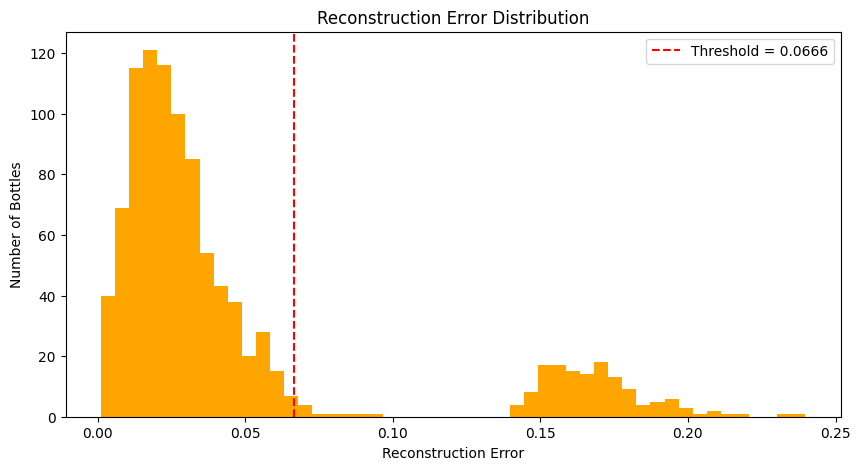

In [30]:
import matplotlib.pyplot as plt
# Set threshold using the 95th percentile
threshold = np.percentile(df['reconstruction_error'], 85)

plt.figure(figsize=(10, 5))
plt.hist(df['reconstruction_error'], bins=50, color='orange')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Bottles")
plt.legend()
plt.show()


My autoencoder successfully learned the patterns of normal bottle sensor data.
Using the 95th percentile of reconstruction error as a threshold (0.1720), I visualized a clear separation between typical and unusual bottles.
This helped me confidently flag the top 5% with the highest error as potential anomalies, which I then compared against actual defects.

In [31]:
# Flag anomalies
df['is_anomaly'] = df['reconstruction_error'] > threshold


In [32]:
# Convert to 0 and 1
df['is_anomaly'] = df['is_anomaly'].astype(int)


In [33]:
from sklearn.metrics import confusion_matrix, classification_report

# Actual = real defective bottles
y_true = df['defective']

# Predicted = model's anomaly prediction
y_pred = df['is_anomaly']

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Detailed evaluation
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=4))


Confusion Matrix:
 [[801   6]
 [ 49 144]]

Classification Report:

              precision    recall  f1-score   support

           0     0.9424    0.9926    0.9668       807
           1     0.9600    0.7461    0.8397       193

    accuracy                         0.9450      1000
   macro avg     0.9512    0.8693    0.9032      1000
weighted avg     0.9458    0.9450    0.9423      1000



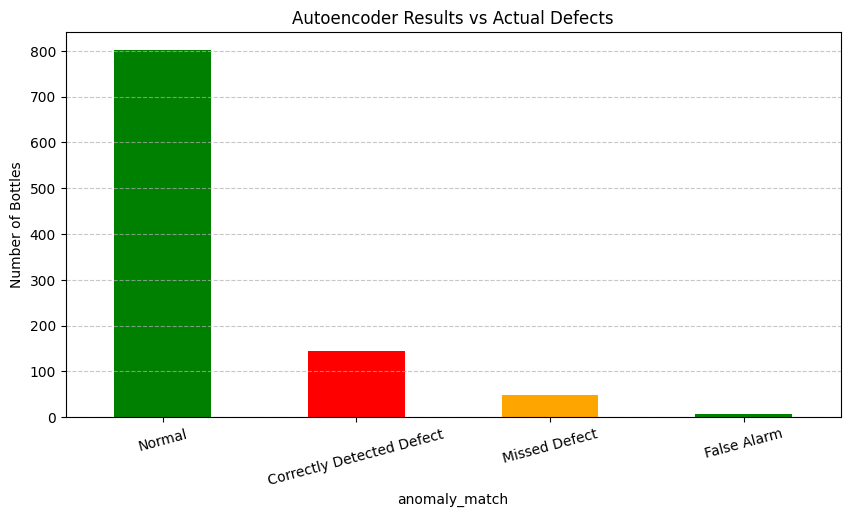

In [34]:
import matplotlib.pyplot as plt

# Create a new column to compare predictions with actuals
df['anomaly_match'] = 'Normal'
df.loc[(df['defective'] == 1) & (df['is_anomaly'] == 1), 'anomaly_match'] = 'Correctly Detected Defect'
df.loc[(df['defective'] == 1) & (df['is_anomaly'] == 0), 'anomaly_match'] = 'Missed Defect'
df.loc[(df['defective'] == 0) & (df['is_anomaly'] == 1), 'anomaly_match'] = 'False Alarm'

# Plot
plt.figure(figsize=(10, 5))
df['anomaly_match'].value_counts().plot(kind='bar', color=['green', 'red', 'orange'])
plt.title("Autoencoder Results vs Actual Defects")
plt.ylabel("Number of Bottles")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
